<a href="https://colab.research.google.com/github/Calista-F/ECG-signal-denoising/blob/main/20220225_Wavelet_runthrough_ECG_pywt_signal_0_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import numpy as np
import pywt
from skimage.restoration import denoise_wavelet
import matplotlib.pyplot as plt
from pylab import *
from matplotlib.pyplot import figure
plt.rcParams.update({'font.family':'serif'})
import pandas as pd
from google.colab import files

from math import log10, sqrt
import cv2
import numpy as np

In [2]:
from sklearn.metrics import  mean_squared_error, mean_absolute_error, max_error
import math

def get_rmse(y_target, y_computed):
  RMSE = mean_squared_error(y_target, y_computed, squared=False)
  return RMSE

In [3]:
def get_min_rmse(df):
  return df[df['RMSE'] == df['RMSE'].min()]

In [4]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

In [5]:
def get_err(noisy,denoised):
  return np.sum((noisy-denoised)**2)

In [6]:
from scipy.misc import electrocardiogram

##Sigma =0.05

In [7]:
x = pywt.data.ecg().astype(float)/256

sigma = 0.05
np.random.seed(0)
x_noisy = x + sigma * np.random.randn(x.size)

In [8]:
signaltonoise(x_noisy)

array(-1.37112039)

In [9]:
np.mean(x)

-0.219940185546875

In [10]:
np.mean(x_noisy)

-0.2221386062223739

In [11]:
np.std(x[300:440])

0.03315092638751392

In [12]:
np.std(x_noisy[300:440])

0.05783037452314455

(-0.6, 0.1)

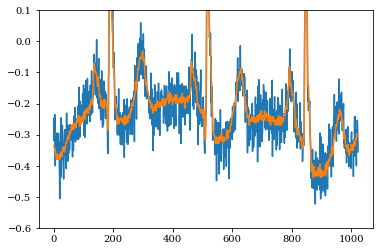

In [13]:
noisy_norm_df = pd.DataFrame(x_noisy)
signal_norm_df = pd.DataFrame(x)
plt.plot(noisy_norm_df)
plt.plot(signal_norm_df)
plt.ylim(-0.6,0.1)

In [14]:
num = np.sum(x_noisy**2)
den = np.sum((x_noisy-x)**2)
snr = 10* np.log10(num/den)
print('SNR: ',snr)

SNR:  14.930766127317757


In [15]:
metrics = ['RMSE','MAE','MAX']
wavelets = ['sym5','db13','coif1']
sym_wavelets = ['sym'+str(i) for i in range(2,21)]
db_wavelets = ['db'+str(i) for i in range(1,39)]
coif_wavelets = ['coif'+str(i) for i in range(1,18)]
levels = np.arange(1,5,1)
methods = ['BayesShrink','VisuShrink']
indexcol = ['RMSE','MAE','MAX']

signalno = 'signal 60'
signaldistance = '5 kpc'

Create a main list that appends each line and each metric result

In [16]:
get_rmse(signal_norm_df, noisy_norm_df)

0.04928380302021446

In [17]:
main_list = []

for m in methods:
  cols = []
  for i in range(len(sym_wavelets)):
    for l in range(len(levels)):
      #Make a dataframe for the denoised signal of the noisy normalized signal
      denoised_df = pd.DataFrame(denoise_wavelet(x_noisy, method = m, mode ='soft', wavelet = sym_wavelets[i], wavelet_levels = levels[l], rescale_sigma = 'True'))
      
      #Create col1- a list that contains the signal properties (which signal template was used), denoising properties, and denoising performance metrics
      col1 = [str(m).upper() +', '+ sym_wavelets[i] + ' level ' + str(levels[l])] 
      col1.append(get_rmse(signal_norm_df, denoised_df))
      col1.append(mean_absolute_error(signal_norm_df, denoised_df))
      col1.append(max_error(signal_norm_df, denoised_df))

      #append this column to cols- a list of columns for the table 
      cols.append(col1)
  main_list.append(cols)

  main_array = np.array(main_list)

In [18]:
def denoising_metrics(wavelet_family, max_level):

  main_list = []
  for m in methods:
    cols = []
    for i in range(len(wavelet_family)):
      for l in range(len(np.arange(1,max_level,1))):
        #Make a dataframe for the denoised signal of the noisy normalized signal
        denoised_df = pd.DataFrame(denoise_wavelet(x_noisy, method = m, mode ='soft', wavelet = wavelet_family[i], wavelet_levels = np.arange(1,max_level,1)[l], rescale_sigma = 'True'))
        
        #Create col1- a list that contains the signal properties (which signal template was used), denoising properties, and denoising performance metrics
        col1 = [str(m).upper() +', '+ wavelet_family[i] + ' level ' + str(levels[l])] 
        col1.append(get_rmse(signal_norm_df, denoised_df))
        col1.append(mean_absolute_error(signal_norm_df, denoised_df))
        col1.append(max_error(signal_norm_df, denoised_df))

        #append this column to cols- a list of columns for the table 
        cols.append(col1)
    main_list.append(cols)
  return np.array(main_list)

In [19]:
df_minrmse = pd.DataFrame()

Symlet wavelet

In [20]:
symlet_array = denoising_metrics(sym_wavelets, 5)
BayesSymdf = pd.DataFrame(data = symlet_array[0,:,1:], columns = metrics, index = symlet_array[0,:,0])
df_minrmse = df_minrmse.append(get_min_rmse(BayesSymdf))


VisuSymdf = pd.DataFrame(data = symlet_array[1,:,1:], columns = metrics, index = symlet_array[1,:,0])
df_minrmse = df_minrmse.append(get_min_rmse(VisuSymdf))

Daubechies wavelet

In [21]:
db_array = denoising_metrics(db_wavelets,4)
BayesDbdf = pd.DataFrame(data = db_array[0,:,1:], columns = metrics, index = db_array[0,:,0])
df_minrmse = df_minrmse.append(get_min_rmse(BayesDbdf))
VisuDbdf = pd.DataFrame(data = db_array[1,:,1:], columns = metrics, index = db_array[1,:,0])
df_minrmse = df_minrmse.append(get_min_rmse(VisuDbdf))

Coiflet wavelet

In [22]:
coif_array = denoising_metrics(coif_wavelets,4)
coif_array.shape
Bayescoifdf = pd.DataFrame(data = coif_array[0,:,1:], columns = metrics, index = coif_array[0,:,0])
df_minrmse = df_minrmse.append(get_min_rmse(Bayescoifdf))
Visucoifdf = pd.DataFrame(data = coif_array[1,:,1:], columns = metrics, index = coif_array[1,:,0])
df_minrmse = df_minrmse.append(get_min_rmse(Visucoifdf))

Minimum RMSEs per threshold method and wavelet family

In [23]:
df_minrmse

,RMSE,MAE,MAX
"BAYESSHRINK, sym11 level 4",0.022128536134568007,0.017419728882529455,0.08543707104665577
"VISUSHRINK, sym5 level 3",0.026422576867835914,0.018464743653521933,0.18061691005587477
"BAYESSHRINK, db6 level 3",0.02296676235340864,0.018048819959720838,0.08497153709314434
"VISUSHRINK, db25 level 2",0.026505891222562656,0.021043178884444694,0.10322927046180248
"BAYESSHRINK, coif2 level 3",0.024120601358847645,0.01840746410334638,0.1099816545454616
"VISUSHRINK, coif2 level 3",0.026559388962690483,0.018360045084700176,0.18965120359549326


In [24]:
bayessym = denoise_wavelet(x_noisy, method = 'BayesShrink', mode ='soft', wavelet = 'sym11', wavelet_levels = 4, rescale_sigma = 'True')
visusym = denoise_wavelet(x_noisy, method = 'VisuShrink', mode ='soft', wavelet = 'sym5', wavelet_levels = 3, rescale_sigma = 'True')

In [25]:
bayesdb = denoise_wavelet(x_noisy, method = 'BayesShrink', mode ='soft', wavelet = 'db6', wavelet_levels = 3, rescale_sigma = 'True')
visudb = denoise_wavelet(x_noisy, method = 'VisuShrink', mode ='soft', wavelet = 'db25', wavelet_levels = 2, rescale_sigma = 'True')

In [26]:
bayescoif = denoise_wavelet(x_noisy, method = 'BayesShrink', mode ='soft', wavelet = 'coif2', wavelet_levels = 3, rescale_sigma = 'True')
visucoif = denoise_wavelet(x_noisy, method = 'VisuShrink', mode ='soft', wavelet = 'coif2', wavelet_levels = 3, rescale_sigma = 'True')

In [27]:
"""
def printsubplots(denoised):
  linewidthplots=0.7
  fig, axs = plt.subplots(1, 2)
  fig.set_size_inches(1, 4)
  axs[0].plot(x_noisy[0:400],alpha = 0.9, linewidth=linewidthplots, label='Noisy')
  axs[0].plot(x[0:400], 'r--', linewidth=linewidthplots, label='Signal')
  axs[0].plot(denoised[0:400], linewidth=linewidthplots, label='Denoised')
  axs[0].legend()
  axs[1].plot((x-denoised)[0:400], linewidth=linewidthplots)
  plt.ylim(-0.4,1)

printsubplots(bayessym)
plt.savefig("bayessym.png")
"""

'\ndef printsubplots(denoised):\n  linewidthplots=0.7\n  fig, axs = plt.subplots(1, 2)\n  fig.set_size_inches(1, 4)\n  axs[0].plot(x_noisy[0:400],alpha = 0.9, linewidth=linewidthplots, label=\'Noisy\')\n  axs[0].plot(x[0:400], \'r--\', linewidth=linewidthplots, label=\'Signal\')\n  axs[0].plot(denoised[0:400], linewidth=linewidthplots, label=\'Denoised\')\n  axs[0].legend()\n  axs[1].plot((x-denoised)[0:400], linewidth=linewidthplots)\n  plt.ylim(-0.4,1)\n\nprintsubplots(bayessym)\nplt.savefig("bayessym.png")\n'

In [61]:
def printsubplots(denoised):
  linewidthplots=0.6
  fig, axs = plt.subplots(1, 2)
  fig.set_size_inches(10, 4)
  axs[0].plot(x_noisy[0:400],'gray', linewidth=linewidthplots, label='Noisy')
  axs[0].plot(x[0:400], 'r', linewidth=linewidthplots, label='Signal')
  axs[0].plot(denoised[0:400],'b', linewidth=linewidthplots, label='Denoised')
  axs[0].legend()
  axs[0].set_xlabel('t (s)')
  axs[1].plot((x-denoised)[0:400], 'b', linewidth=linewidthplots)
  axs[1].set_xlabel('t (s)')
  plt.ylim(-0.4,1)
  plt.tight_layout()

def savensave(figname):
  plt.savefig(figname,pad_inches=0,transparent=True, dpi=300)
  files.download(figname)

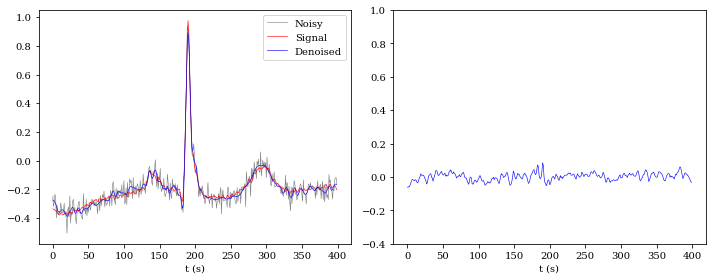

In [62]:
printsubplots(bayessym)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

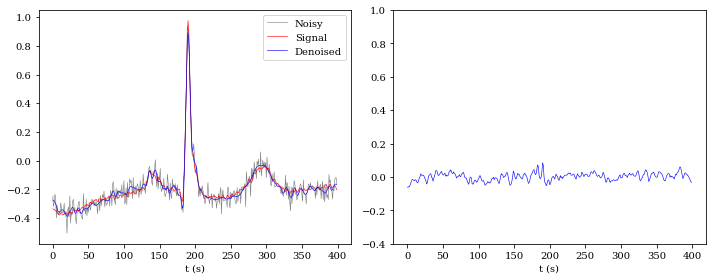

In [63]:
printsubplots(bayessym)
savensave("bayesssym5.png")

In [64]:
np.mean((x-bayessym)[0:400])

0.0016283686976513781

In [65]:
np.std((x-bayessym)[0:400])

0.02300217330959871

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

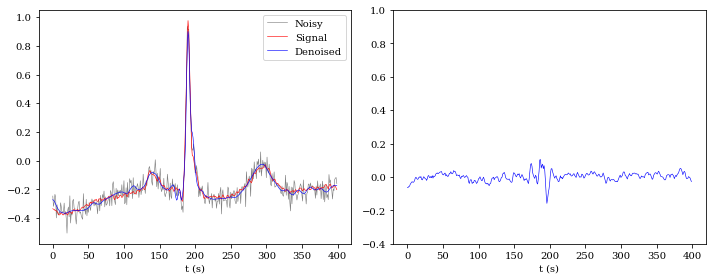

In [66]:
printsubplots(visusym)
savensave("visusym5.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

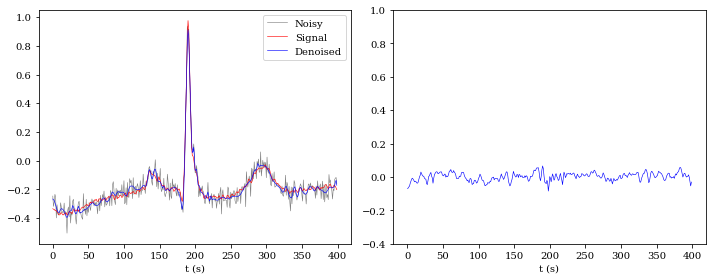

In [67]:
printsubplots(bayesdb)
savensave("bayesdb5.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

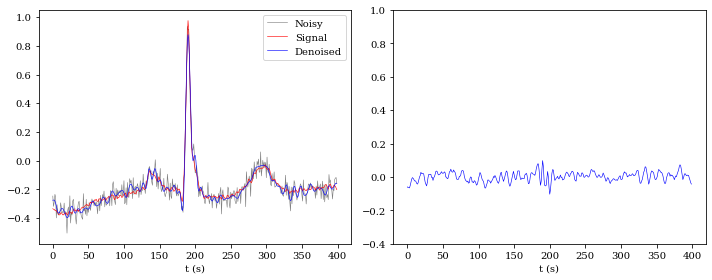

In [68]:
printsubplots(visudb)
savensave("visudb5.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

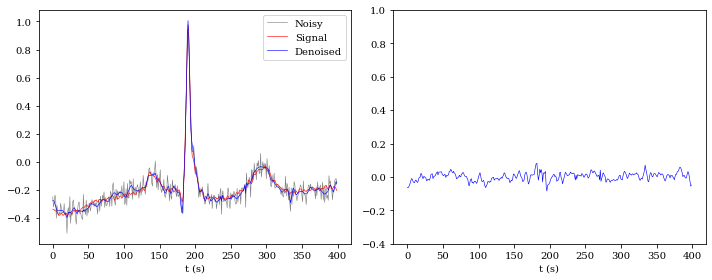

In [69]:
printsubplots(bayescoif)
savensave("bayescoif5.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

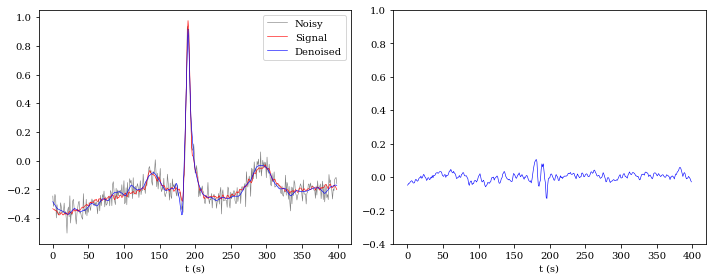

In [70]:
printsubplots(visucoif)
savensave("visucoif5.png")